# Alternative Algos

In [1]:
from IPython.display import display, Markdown

with open("README.md", "r") as f:
    text = "".join(f.readlines())
    
display(Markdown(text))

This addresses the reviewers critique of LazyFOX only being compared to FOX, not to other approaches.

This contains runs of other algorithms (`oslom v2`, `bigClam`,`core-expansion`) on our three core datasets (`EU-core`, `DBLP`, `LiveJournal`).

`oslom` and `core-expansion` struggled to compute results for the `liveJournal` dataset due to its size.
We ran `oslom` with default arg (10 runs on hierarchy 0, 50 runs on higher hierarchies), which we aborted after `68 hours`, having not finished the third run of the first ten.
We then re-ran `oslom` changing the run count to just 1 for hierarchy 0, and skipping all higher hierarchy runs.

`core-expansion` already struggled computation on `DBLP`, which took `32 hours`, which is why we did not start computation on `LiveJournal`.

# TODO
Compare the results of LazyFOX, and the other three algorihtms on the three datasets in terms of F1 and ONMI.

In [2]:
import pickle

with open("alternative_scores.pickle", "rb") as f:
    alternative_dataframes = pickle.load(f)
    
with open("lazyFOX_scores.pickle", "rb") as f:
    lazyfox_dataframes = pickle.load(f)

In [3]:
alternative_dataframes

{'eu':   Dataset   Runtime        F1  NMI Distance Algorithm
 0      eu  2.773455  0.097267      0.996758  big_clam
 0      eu  3.948965  0.123576      1.000000  core_exp
 0      eu -1.000000  0.648454      0.553498     oslom,
 'dblp':   Dataset        Runtime        F1  NMI Distance Algorithm
 0    dblp     811.162802  0.008093      1.000000  big_clam
 0    dblp  115997.683404  0.031101      1.000000  core_exp
 0    dblp      -1.000000  0.121664      0.963287     oslom,
 'lj':   Dataset       Runtime        F1 NMI Distance Algorithm
 0      lj  12733.231291  0.002693          1.0  big_clam
 0      lj           NaN       NaN          NaN  core_exp
 0      lj            -1  0.112168     0.988821     oslom}

/tmp/ipykernel_52416/898186181.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fox["Algorithm"] = "FOX"


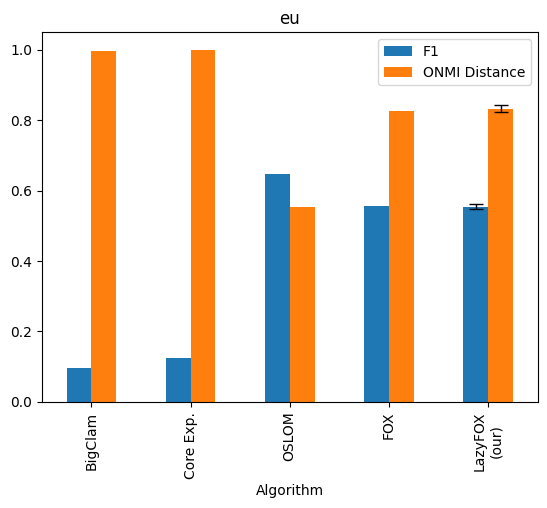

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd

plt.rcParams.update({'hatch.color': 'tab:green'})

def plot_scores(dataset, cols=["F1", "NMI Distance"], ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    # Alternative Algos
    alt_df = alternative_dataframes[dataset].copy()
    alt_df.replace("oslom", "OSLOM", inplace=True)
    alt_df.replace("big_clam", "BigClam", inplace=True)
    alt_df.replace("core_exp", "Core Exp.", inplace=True)
    
    alt_df.index = alt_df["Algorithm"]
    alt_df.replace("NaN", 0, inplace=True)
    
    # LazyFox Raw
    lf_df = lazyfox_dataframes[dataset].copy()
    lf_df["Algorithm"] = lf_df["Algorithm"] + "_" + lf_df["queue_size"].astype(str)
    lf_df.index = lf_df["Algorithm"]
    lf_df.replace("NaN", 0, inplace=True)
    # Fox
    fox = lf_df[lf_df["queue_size"] == 1]
    fox["Algorithm"] = "FOX"
    fox = fox.set_index("Algorithm")
    # LazyFox min, max, mean
    all_lazyfox = lf_df[lf_df["queue_size"] != 1]
    lf_mean = all_lazyfox[["F1", "NMI Distance"]].mean()
    lf_min = lf_mean - all_lazyfox[["F1", "NMI Distance"]].min()
    lf_max = all_lazyfox[["F1", "NMI Distance"]].max() - lf_mean
        
    mean_lf_df = pd.DataFrame([{
        "Dataset": dataset,
        "Runtime": -1,
        "F1": lf_mean["F1"],
        "NMI Distance": lf_mean["NMI Distance"],
        "Algorithm": "LazyFOX\n(our)",
    }])
    mean_lf_df = mean_lf_df.set_index("Algorithm")
    
    bar = pd.concat([alt_df, fox, mean_lf_df]).plot.bar(
        y=cols,
        title=dataset,
        ax=ax,
    )
    

    # Manual Insertion of LazyFox MAX MAX bars
    # F1
    err_bar = ax.errorbar(
        x=ax.patches[4].get_x() + ax.patches[4].get_width() / 2,
        y=ax.patches[4].get_height(),
        yerr=[
            [lf_min["F1"]], # Down
            [lf_max["F1"]], # Up
        ],
        capsize=5,
        elinewidth=1,
        markeredgewidth=1,
        ecolor="black",
    )

    # ONMI
    ax.errorbar(
        x=ax.patches[9].get_x() + ax.patches[9].get_width() / 2,
        y=ax.patches[9].get_height(),
        yerr=[
            [lf_min["NMI Distance"]], # Down
            [lf_max["NMI Distance"]], # Up
        ],
        capsize=5,
        elinewidth=1,
        markeredgewidth=1,
        ecolor="black",
    )
        
    # Legend
    handles, labels = ax.get_legend_handles_labels()
    # circ1 = mpatches.Patch(facecolor="w", alpha=0, hatch="///", label='Mean')

    # bar.patches[4].set_hatch("/")
    # bar.patches[9].set_hatch("/")
    # Remove the black line in the legend handle by making it invisible
    # handles[-1].lines[0].set_alpha(0)
    
    ax.legend(
        labels=["F1", "ONMI Distance"]
    )

plot_scores("eu")

/tmp/ipykernel_52416/898186181.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fox["Algorithm"] = "FOX"


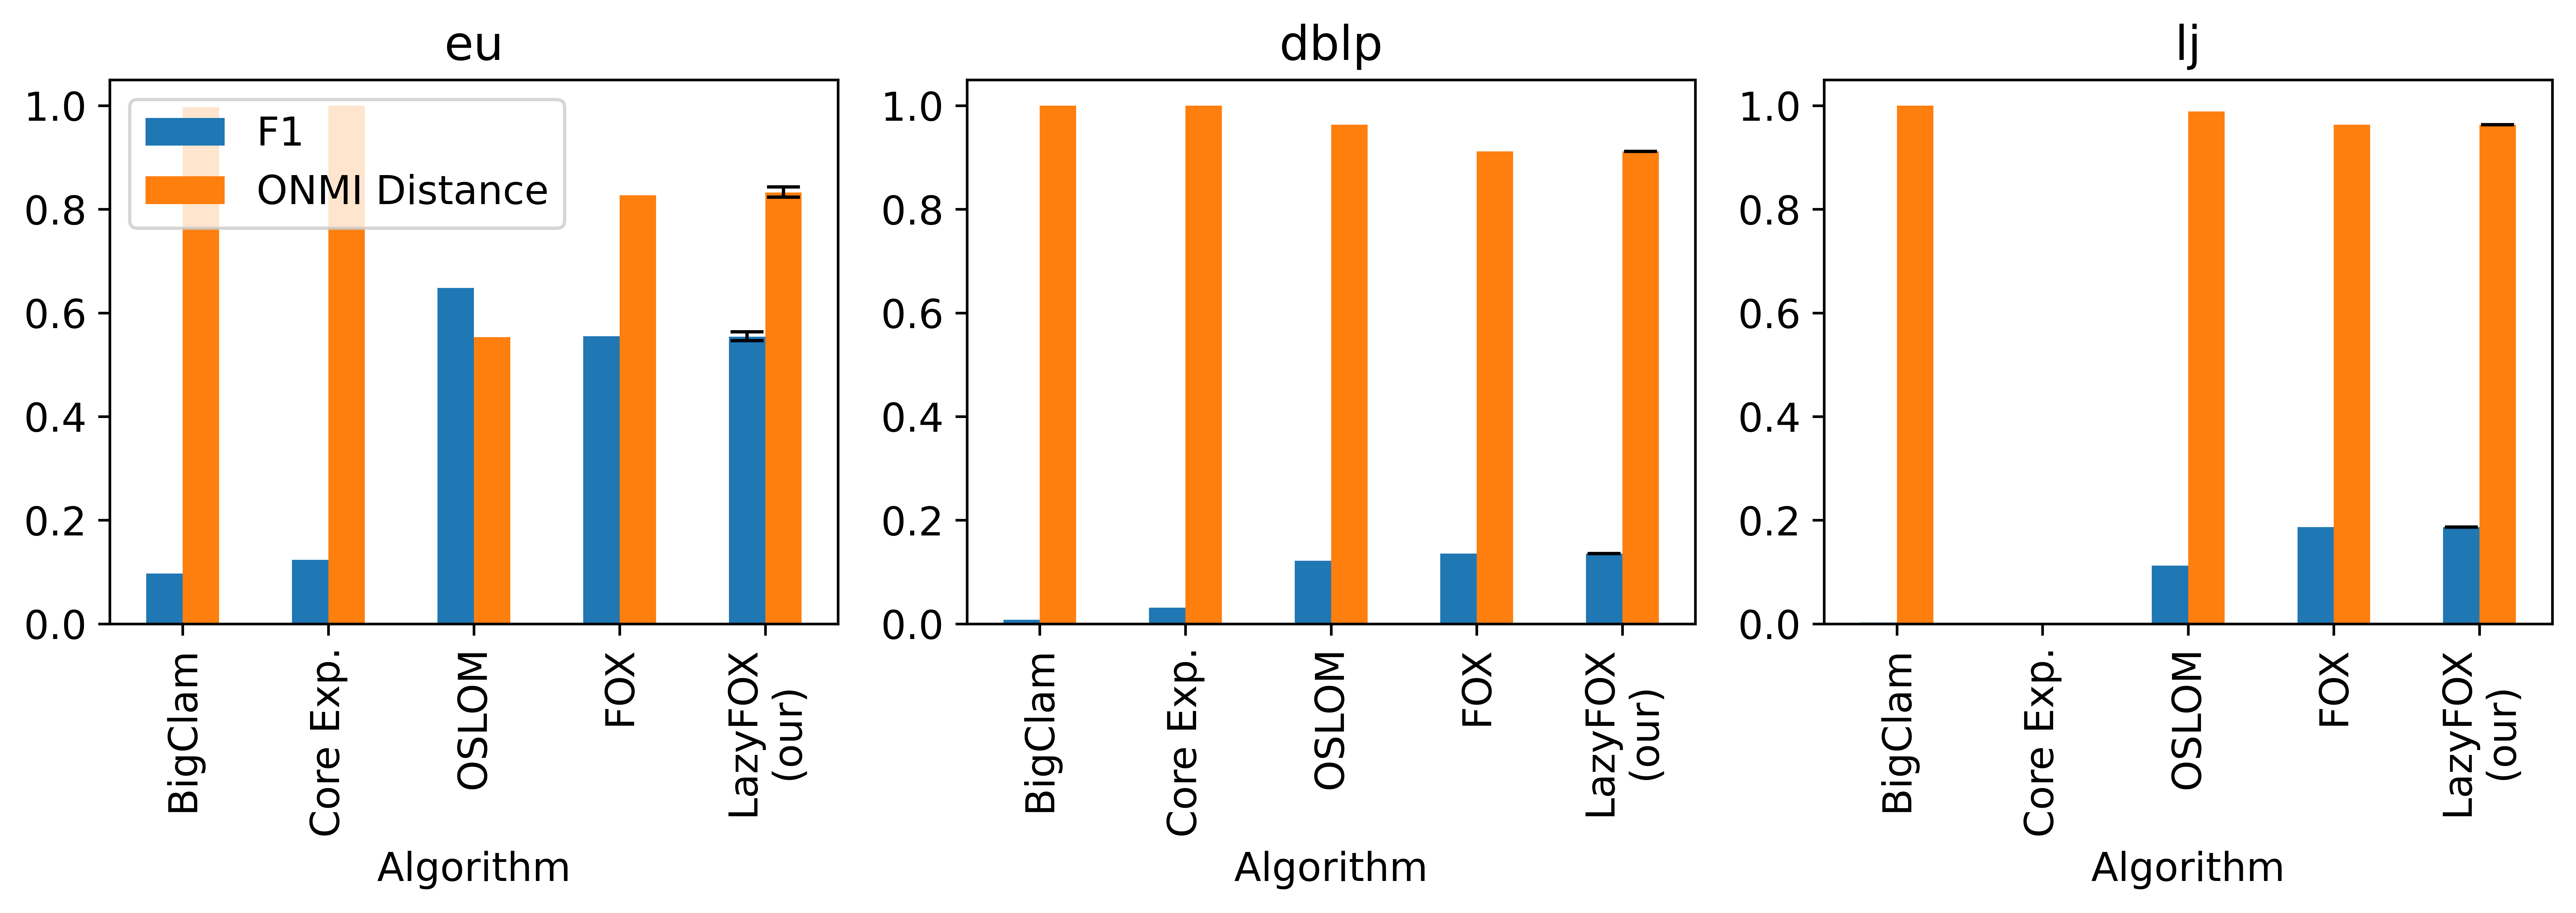

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(11,4), dpi=1024)

plot_scores("eu", ax=ax1)
plot_scores("dblp", ax=ax2)
plot_scores("lj", ax=ax3)

ax2.get_legend().remove()
ax3.get_legend().remove()

plt.tight_layout()

In [6]:
fig.savefig('figures_alternative_algos_bar.pdf')  